In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
using Plots

In [4]:
n_samples = 101

101

In [5]:
phase_x = zeros(Float32, 1, n_samples)

1×101 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
phase_y = range(start = -1.0, stop = 1.0, length = n_samples) |> collect;
phase_y = reshape(phase_y, 1, n_samples);

In [7]:
phase_z = bind(phase_x, phase_y)

1×101 Matrix{Float64}:
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  -1.0

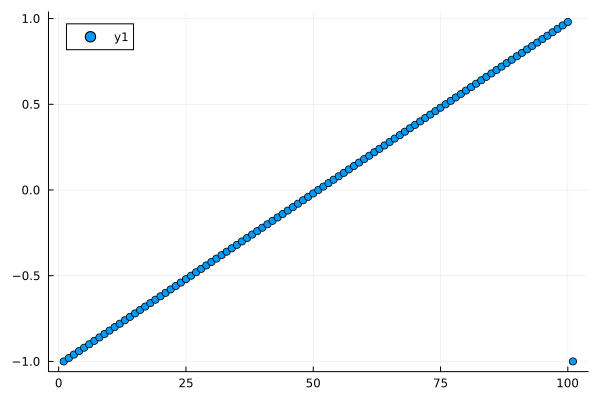

In [8]:
scatter(phase_z |> vec)

In [9]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [10]:
st_x = phase_to_train(phase_x, spk_args, repeats = 3)
st_y = phase_to_train(phase_y, spk_args, repeats = 3)

Spike Train: (1, 101) with 303 spikes.

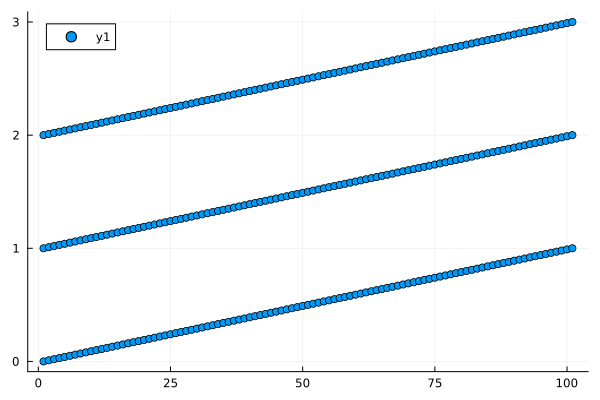

In [12]:
scatter(getindex.(st_y.indices, 2), st_y.times)

In [13]:
tspan = (0.0, 3.0)

(0.0, 3.0)

In [15]:
using OrdinaryDiffEq

In [17]:
sa = SpikingArgs(threshold = 1e-4)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.0001 (V)


In [18]:
neuron_constant(sa)

-0.2 + 6.283185307179586im

In [107]:
fieldnames(typeof(sa))

(:leakage, :t_period, :t_window, :threshold, :dt)

In [108]:
SpikingCall

SpikingCall

In [110]:
st_x.shape

(1, 101)

In [131]:
k = neuron_constant(spk_args)
k_osc = 1im * imag(k)
k_mem = real(k)
k_rvs = real(k) + -1.0im * imag(k)

#create a reference oscillator to generate complex values for each moment in time
sol_ref(t) = exp.(k_osc .* (t .- st_x.offset))

sol_ref (generic function with 1 method)

In [132]:
k

-0.2 + 6.283185307179586im

In [133]:
k_osc

0.0 + 6.283185307179586im

In [134]:
k_mem

-0.2

In [135]:
k_rvs

-0.2 - 6.283185307179586im

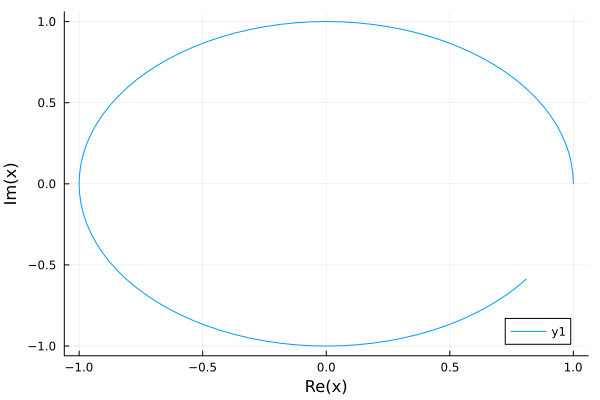

In [141]:
vs = sol_ref.(0.0:0.01:0.9)
plot(vs)

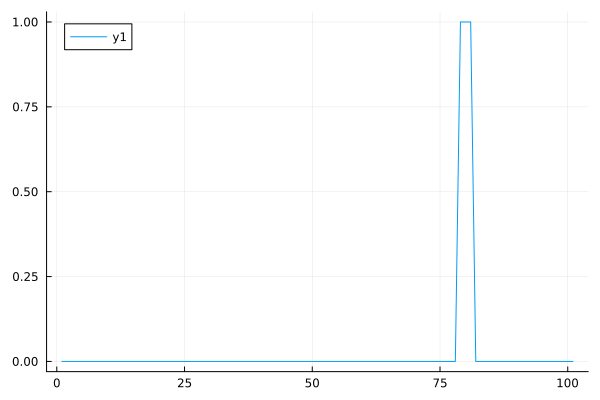

In [152]:
plot(abs.(sol_ref(0.8) .* spike_current(st_y, 0.79, sa)) |> vec)

In [167]:
function bind(x::SpikeTrain, y::SpikeTrain, tspan::Tuple{<:Real, <:Real}, spk_args::SpikingArgs; return_solution::Bool = false)
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)
    k_osc = imag(k)
    k_mem = real(k) + 0.0im
    k_rvs = real(k) + -1.0im * imag(k)

    #get the number of batches & output neurons
    output_shape = x.shape

    #create a reference oscillator to generate complex values for each moment in time
    sol_ref(t) = exp.(1im .* k_osc .* (t .- x.offset))

    #set up the memory compartment
    u0_mem = zeros(ComplexF32, output_shape)
    dzdt_mem(u, p, t) = k_mem .* u .+ sol_ref(t) .* spike_current(x, t, spk_args)
    #solve the memory compartment
    prob_mem = ODEProblem(dzdt_mem, u0_mem, tspan)
    sol_mem = solve(prob_mem, Heun(), adaptive=false, dt=spk_args.dt)

    #set up the countdown compartment
    u0_rvs = zeros(ComplexF32, output_shape)
    dzdt_rvs(u, p, t) = k_rvs .* u .+ sol_mem(t) .* spike_current(y, t, spk_args)
    prob_rvs = ODEProblem(dzdt_rvs, u0_rvs, tspan)
    sol_rvs = solve(prob_rvs,  Heun(), adaptive=false, dt=spk_args.dt)

    if return_solution
        return sol_mem, sol_rvs
    end

    indices, times = find_spikes_rf(sol_rvs, spk_args, reverse=true)
    #construct the spike train and call for the next layer
    train = SpikeTrain(indices, times, output_shape, x.offset + spk_args.t_period / 4.0)
    next_call = SpikingCall(train, spk_args, tspan)
    return next_call

end

bind (generic function with 5 methods)

In [168]:
solx, soly = bind(st_y, st_y, tspan, sa, return_solution=true)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt_mem#89"{SpikeTrain, SpikingArgs, var"#sol_ref#88"{SpikeTrain, Float64}, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Heun{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt_mem#89"{SpikeTrain, SpikingArgs, var"#sol_ref#88"{SpikeTrain, Float64}, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Noth

In [169]:
ux = Array(solx)
uy = Array(soly);

In [170]:
function plot_neuron(u, idx)
    plot(real.(u[1, idx, :]))
    plot!(imag.(u[1, idx, :]))
end

plot_neuron (generic function with 1 method)

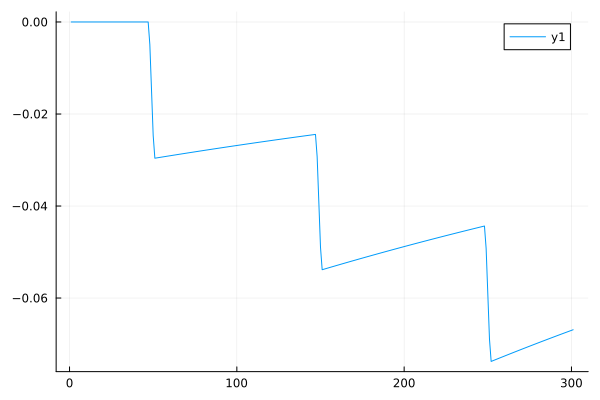

In [171]:
plot(real.(ux[1,50,:]))

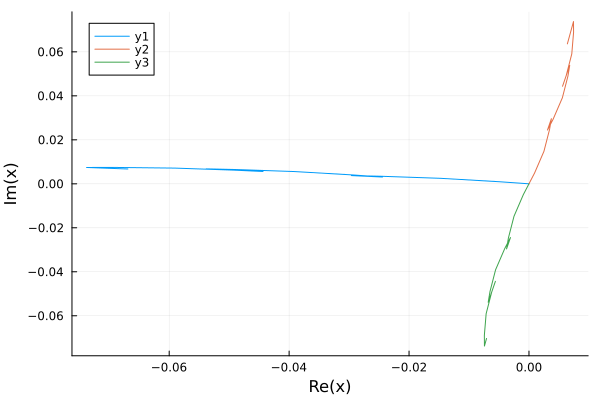

In [172]:
plot(ux[1,50,:])
plot!(ux[1,25,:])
plot!(ux[1,75,:])

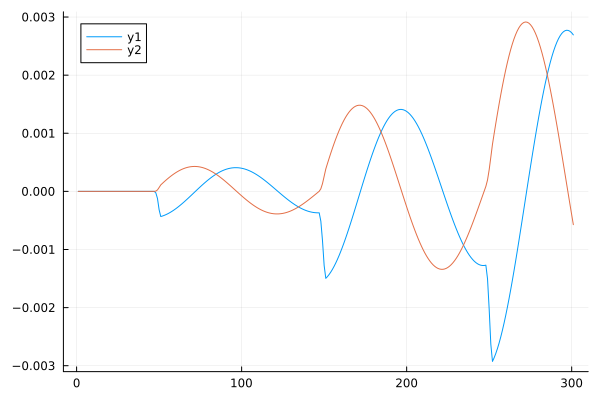

In [173]:
plot_neuron(uy, 50)

In [174]:
uy[1,50,:]

301-element Vector{ComplexF32}:
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
          0.0f0 + 0.0f0im
                ⋮
 0.0026776304f0 + 0.0008091318f0im
 0.0027177327f0 + 0.00063801394f0im
 0.0027469455f0 + 0.00046506114f0im
  0.002765197f0 + 0.00029096348f0im
  0.002772459f0 + 0.000116412826f0im
 0.0027687468f0 - 5.7899906f-5im
  0.002754119f0 - 0.0002312875f0im
 0.0027286767f0 - 0.00040306913f0im
 0.0026925637f0 - 0.0005725731f0im

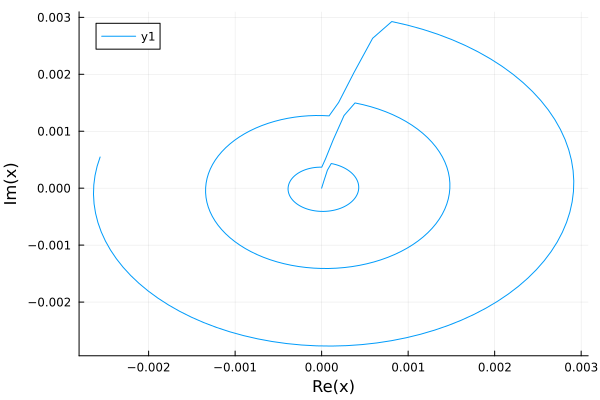

In [175]:
plot(uy[1,25,:])

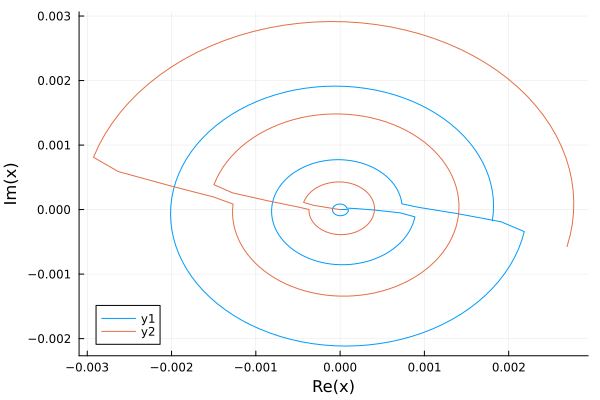

In [176]:
plot(uy[1,1,:])
plot!(uy[1,50,:])
#plot!(uy[1,75,:])

In [177]:
idx, t = find_spikes_rf(soly, sa, reverse=true)

(CartesianIndex{2}[CartesianIndex(1, 28), CartesianIndex(1, 29), CartesianIndex(1, 30), CartesianIndex(1, 31), CartesianIndex(1, 32), CartesianIndex(1, 33), CartesianIndex(1, 34), CartesianIndex(1, 35), CartesianIndex(1, 36), CartesianIndex(1, 37)  …  CartesianIndex(1, 60), CartesianIndex(1, 10), CartesianIndex(1, 11), CartesianIndex(1, 12), CartesianIndex(1, 61), CartesianIndex(1, 62), CartesianIndex(1, 13), CartesianIndex(1, 63), CartesianIndex(1, 64), CartesianIndex(1, 14)], [0.2900000000000001, 0.3000000000000001, 0.3200000000000001, 0.3200000000000001, 0.34000000000000014, 0.38000000000000017, 0.38000000000000017, 0.4000000000000002, 0.4200000000000002, 0.4400000000000002  …  2.899999999999982, 2.9199999999999817, 2.9399999999999813, 2.9399999999999813, 2.9399999999999813, 2.9399999999999813, 2.9799999999999804, 2.9799999999999804, 2.9799999999999804, 2.9899999999999802])

In [178]:
function get_ts(idx, ts, nn)
    n = getindex.(idx, 2)
    t = ts[n .== nn]
    return t
end

get_ts (generic function with 1 method)

In [179]:
get_ts(idx, t, 1)

2-element Vector{Float64}:
 1.7300000000000013
 2.7299999999999858

In [180]:
get_ts(idx, t, 50)

3-element Vector{Float64}:
 0.7000000000000004
 1.7000000000000013
 2.709999999999986

In [181]:
v2 = Array(soly(get_ts(idx, t, 50)))

1×101×3 Array{ComplexF64, 3}:
[:, :, 1] =
 -3.43473e-5+7.99915e-5im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im

[:, :, 2] =
 -0.000191444+0.000755313im  …  -7.18776e-5+0.000382694im

[:, :, 3] =
 -0.000299347+0.00189899im  …  -0.000163239+0.00133365im

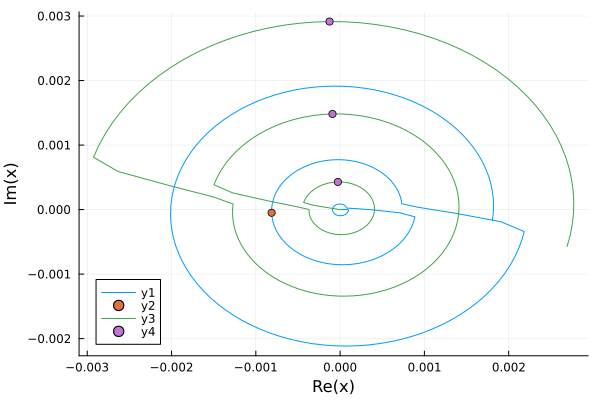

In [182]:
plot(uy[1,1,:])
v1 = soly(1.48)[1,1]
scatter!([real(v1)], [imag(v1)])
v2 = Array(soly(get_ts(idx, t, 50)))[1,50,:]
plot!(uy[1,50,:])
scatter!(real.(v2), imag.(v2))

In [183]:
size(ux, 3)

301

┌ Info: Saved animation to /var/folders/qc/b4ggx3516_qc8fy84rgtp36c0000gq/T/jl_kvqzy7KXS5.gif
└ @ Plots /Users/wilkie/.julia/packages/Plots/p3KMq/src/animation.jl:156


Plots.AnimatedGif("/var/folders/qc/b4ggx3516_qc8fy84rgtp36c0000gq/T/jl_kvqzy7KXS5.gif")
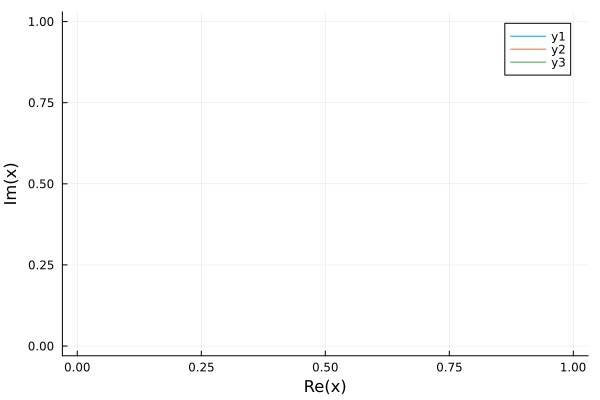

In [184]:
#plot(uy[1,1,1:1])

n_t = size(uy,3)
@gif for i in 1:n_t
    plot(uy[1,1,1:i] |> vec)
    plot!(uy[1,25,1:i] |> vec)
    plot!(uy[1,50,1:i] |> vec)
end every 1

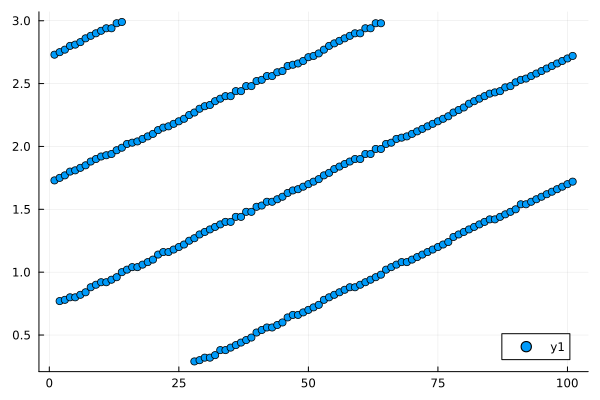

In [185]:
scatter(getindex.(idx,2), t)

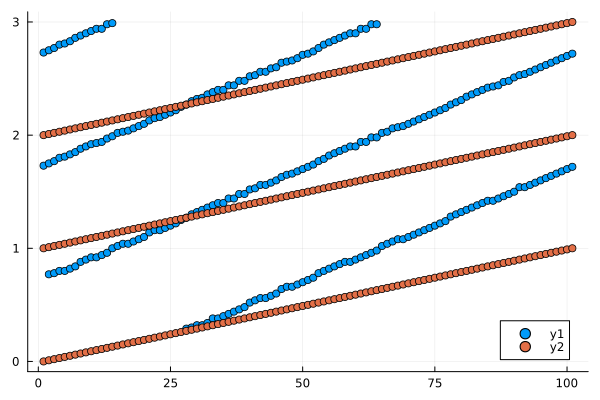

In [186]:
scatter(getindex.(idx,2), t)
scatter!(getindex.(st_y.indices, 2), st_y.times)

In [80]:
ph = train_to_phase(st_z, sa);

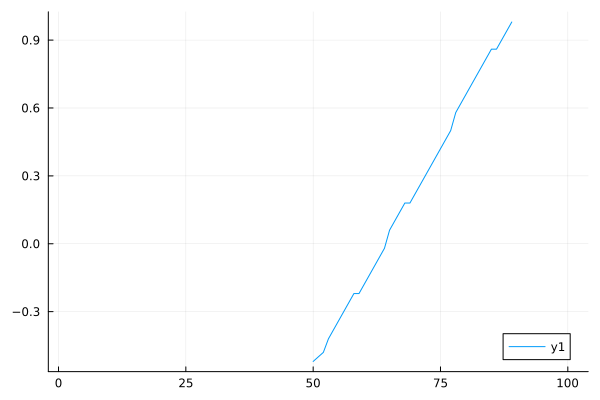

In [83]:
plot(ph[1,1,:])

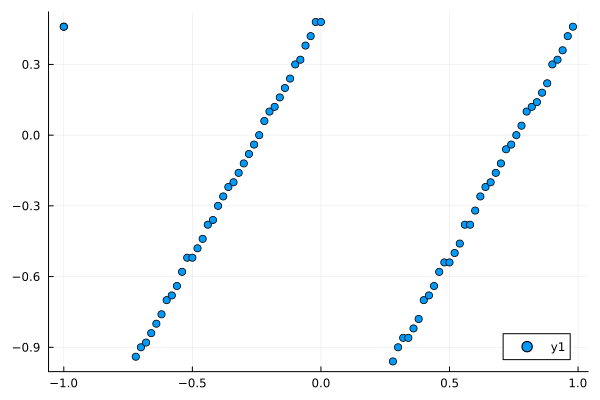

In [407]:
scatter(phase_z |> vec, ph[end,1,:])

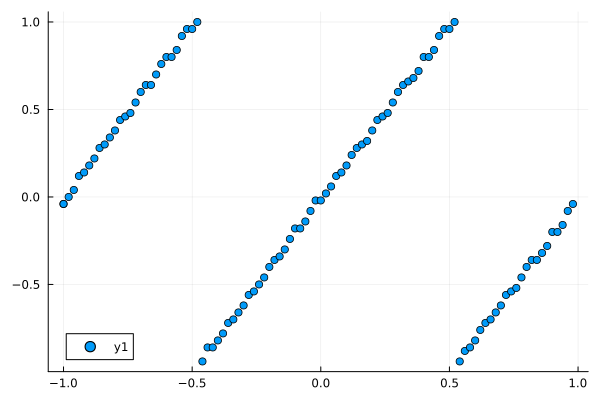

In [357]:
scatter(phase_z |> vec, ph[8,1,:])

In [21]:
u = dropdims(Array(st_z), dims=1)

101×1001 Matrix{ComplexF32}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …          0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  …          0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im             0.0+0.0im
    ⋮                                        ⋱             ⋮
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im      -0.0022957+0.00455428im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -0.00283735+0.00421349im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im     -0.00333001+0.00380907im
 0.0+0.0im  0.0+0.0im  0.0+0.0i

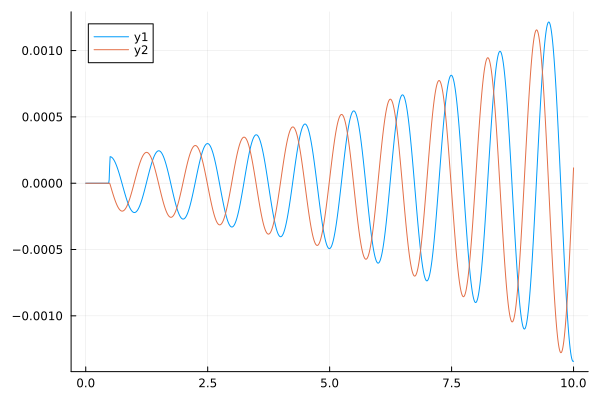

In [22]:
plot(st_z.t, real.(u[50, :]) )
plot!(st_z.t, imag.(u[50, :]))

In [23]:
u |> size

(101, 1001)

In [24]:
find_spikes_rf(st_z, sa)

(CartesianIndex{2}[CartesianIndex(1, 50), CartesianIndex(1, 51), CartesianIndex(1, 52), CartesianIndex(1, 53), CartesianIndex(1, 54), CartesianIndex(1, 55), CartesianIndex(1, 56), CartesianIndex(1, 57), CartesianIndex(1, 58), CartesianIndex(1, 59)  …  CartesianIndex(1, 55), CartesianIndex(1, 56), CartesianIndex(1, 57), CartesianIndex(1, 58), CartesianIndex(1, 59), CartesianIndex(1, 60), CartesianIndex(1, 61), CartesianIndex(1, 62), CartesianIndex(1, 63), CartesianIndex(1, 64)], [0.7400000000000004, 0.7500000000000004, 0.7600000000000005, 0.7900000000000005, 0.8100000000000005, 0.8300000000000005, 0.8500000000000005, 0.8700000000000006, 0.8900000000000006, 0.8900000000000006  …  9.829999999999835, 9.849999999999834, 9.869999999999834, 9.889999999999834, 9.889999999999834, 9.909999999999833, 9.929999999999833, 9.949999999999832, 9.969999999999832, 9.989999999999831])

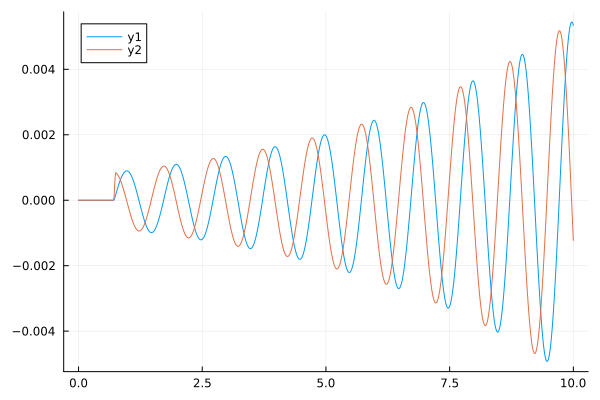

In [57]:
plot(st_z.t, real.(u[75, :]) )
plot!(st_z.t, imag.(u[75, :]))

In [40]:
find_spikes_rf(st_z, sa)

(CartesianIndex{2}[], Float64[])